In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt

# we use the scikit svm model for this experiment 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

!pip install scikit-plot
import scikitplot as skplt

In [2]:
# model evaluation 
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from statistics import mean

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# import the preprocessing functions we've made 
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/'

import preprocess

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/persuasiveness/data/'

/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/persuasiveness/data


In [5]:
# import the advertising dataset 
# Each ad has a binary label 0 for commercial and 1 for informational ads 
df= pd.read_csv('training_dataset_18k.csv') 

df=df.sample(frac=1)

In [6]:
import re 
# Functions for removing contractions 
contraction_dict = {"you'll":"you will", "we're": "we are","ain't": "are not","'s":" is","aren't": "are not", "won't": "would not", "don't": "do not", "isn't": "is not", "it's" : "it is"}
def expand_contractions(data,contractions_dict = contraction_dict):
  '''
    Expanding Contractions
    Arguments:
      data: textual dataset 
      contractions_dict : dictionanary containing the contractions and their replacements 
    Returns :
      clean_data : textual dataset where contractions are expanded
  '''
  # Regular expression for finding contractions
  contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
  def replace(match):
      return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, data)

In [7]:
import string
df['ad'] = df['ad'].str.strip().str.lower() 

# Expand contractions 
df['ad'] = df['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df['ad'] =  df['ad'].str.translate(str.maketrans('','',string.punctuation))

In [8]:
df.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df

,ad,persuasive
16406,president trump is broadening his push to over...,1
17174,it is known that entrepreneurship in general h...,1
2117,may this week serve as a vivid illustration an...,0
17997,senior systems engineer is big data applyrecru...,1
8171,blais a candidate to believe in right choice f...,1
...,...,...
11843,i will personally pay to anyone who is able t...,1
5226,a local study on covid is looking for particip...,0
841,showing up amp working for you,0
15644,we are on a roll look at these progressive pri...,1


In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


In [10]:
# vectorize testing and training data 
train_data, test_data = preprocess.eval_train_split(df['ad'], df['persuasive'] , test_size = 0.2, validation = False)
X_train, y_train, X_test, y_test = train_data[0], train_data[1], test_data[0], test_data[1]

tf_vectorizer = CountVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [11]:
clf =RandomForestClassifier(n_estimators=100)
clf.fit(X_train_tf, y_train)

RandomForestClassifier()

accuracy:   0.942
              precision    recall  f1-score   support

 no-scarcity       0.90      0.90      0.90      1107
    scarcity       0.96      0.96      0.96      2633

    accuracy                           0.94      3740
   macro avg       0.93      0.93      0.93      3740
weighted avg       0.94      0.94      0.94      3740

confusion matrix:
[[ 994  113]
 [ 105 2528]]



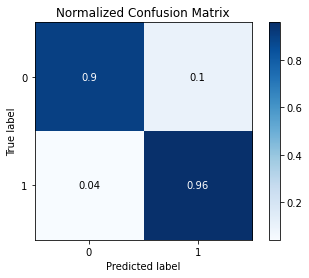

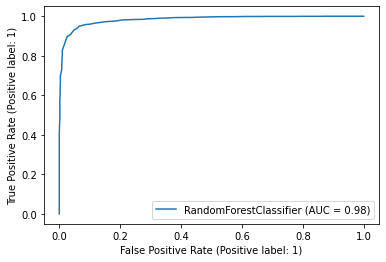

In [12]:
# predict the labels on validation dataset
predictions = clf.predict(X_test_tf)

# compute the performance measures
score = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_test, predictions, target_names=['no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_test_tf, y_test)

In [14]:
df_val = pd.read_csv('sample.csv')
df_val=df_val.sample(frac=1)
df_val.drop_duplicates(subset ="ad ",
                     keep = "first", inplace = True)

df_val['ad '] = df_val['ad '].str.strip().str.lower() 

# Expand contractions 
df_val['ad '] = df_val['ad '].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df_val['ad '] =  df_val['ad '].str.translate(str.maketrans('','',string.punctuation))
df_val


,ad,persuasive
167,save bees and farmers bees are essential to li...,1
180,urgent the supreme court has allowed texas’ un...,1
187,many neglected diseases are also climatesensit...,1
87,we have until march 31st to raise money for ou...,1
116,there’s no time left for promises climate chan...,1
...,...,...
7,our data center in odense denmark recycles ren...,0
51,on this year is international women is day we ...,1
19,hear from the office of tourism and internatio...,1
238,trying to explain social media to our grandpar...,0


In [15]:
X_val = tf_vectorizer.transform(df_val['ad '])
y_val = df_val['persuasive']

accuracy:   0.854
               precision    recall  f1-score   support

no-persuasive       0.88      0.45      0.59        49
   persuasive       0.85      0.98      0.91       156

     accuracy                           0.85       205
    macro avg       0.86      0.71      0.75       205
 weighted avg       0.86      0.85      0.84       205

confusion matrix:
[[ 22  27]
 [  3 153]]



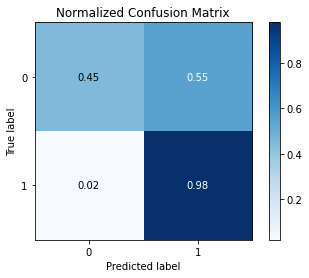

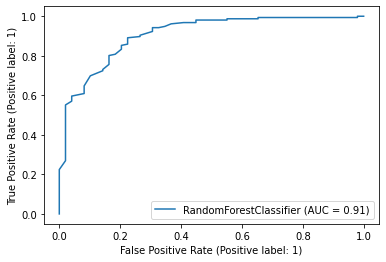

In [16]:
y_pred = clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-persuasive', 'persuasive']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val)